In [1]:
from qiskit.circuit.library import EfficientSU2, TwoLocal
from qiskit_optimization import QuadraticProgram
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA, SLSQP, CRS
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider, YahooDataProvider
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_finance import QiskitFinanceError
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_algorithms.utils import algorithm_globals
from qiskit.visualization import plot_histogram
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver  # For an exact (classical) minimum eigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer  # Qiskit's wrapper to use eigensolvers with optimization problems

num_assets = 10 # set number of assets (= number of qubits)

In [2]:
from pyqubo import Binary
import numpy as np
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import TwoLocal

# Generate data

In [3]:

np.random.seed(42)
n_properties = 10
budget = 3

# Step 1: Set a known optimal bitstring (with exactly `budget` ones)
X_opt = np.zeros(n_properties)
X_opt[[1, 4, 7]] = 1  # you choose these positions
X_opt = X_opt.astype(int)

# Step 2: Generate premiums (mu)
mu = np.random.uniform(0.05, 0.15, n_properties)

# Boost the premiums of the "true" optimal ones
mu[X_opt == 1] += 0.2  # make them significantly more attractive

# Step 3: Build a correlation matrix (sigma)
# Low correlation between selected properties
base_corr = np.random.uniform(0.1, 0.3, (n_properties, n_properties))
correlation_matrix = (base_corr + base_corr.T) / 2
np.fill_diagonal(correlation_matrix, 1)

# Now, add stronger correlation between non-optimal properties to make them riskier
for i in range(n_properties):
    for j in range(n_properties):
        if X_opt[i] == 0 and X_opt[j] == 0 and i != j:
            correlation_matrix[i, j] += 0.3  # make non-selected more correlated

# Step 4: Turn into covariance-like structure
sigma = correlation_matrix * np.outer(mu, mu)

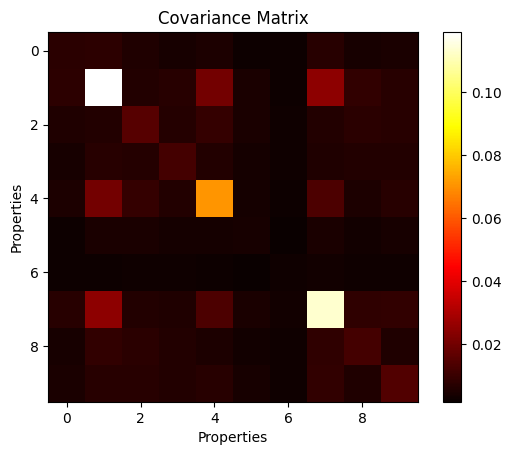

In [4]:
# plot sigma as image
import matplotlib.pyplot as plt

plt.imshow(sigma, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Covariance Matrix")
plt.xlabel("Properties")
plt.ylabel("Properties")
plt.show()

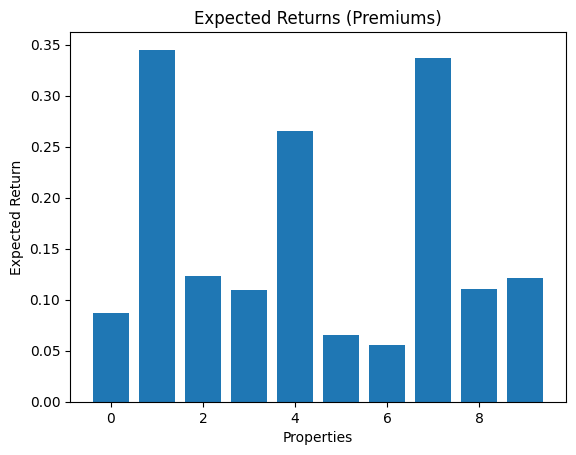

In [5]:
# Plot mu as bar chart
plt.bar(range(n_properties), mu)
plt.title("Expected Returns (Premiums)")
plt.xlabel("Properties")
plt.ylabel("Expected Return")
plt.show()

# try 1


In [6]:
# Parameters
from pyqubo import Binary

q = 0.05
lambda_val = 30
n =10  # Number of properties
B = 3

x = [Binary(f'x_{i}') for i in range(n)]
risk_term = 0
for i in range(n):
    for j in range(n):
        risk_term += sigma[i, j] * x[i] * x[j]

risk_term = risk_term * q

reward = 0
for i in range(n):
    reward -= mu[i] * x[i]

penatly = 0
for i in range(n):
    penatly += x[i] 

penalty = lambda_val * (penatly - B)**2

H = reward - risk_term + penalty



model = H.compile()

qubo, offset = model.to_qubo()

from qiskit_optimization import QuadraticProgram
qp = QuadraticProgram()

# Add binary variables (Assuming our variables are named 'x_0', 'x_1', ... 'x_9')
for i in range(n):
    qp.binary_var(name=f'x_{i}')

# Prepare dictionaries for the linear and quadratic terms
linear = {}
quadratic = {}
for key, coeff in qubo.items():
    if len(key) == 1:
        var_name = key[0]  # e.g., 'x_0'
        linear[var_name] = coeff
    elif len(key) == 2:
        var1, var2 = key  # e.g., 'x_0', 'x_1'
        quadratic[(var1, var2)] = coeff

qp.minimize(linear=linear, quadratic=quadratic)

# Now, printing qp should show the variables and the objective
print(qp)



minimize -150.08783642209448*x_0^2 + 59.99922087871064*x_0*x_1 + 59.99941388044578*x_0*x_2 + 59.99958354395654*x_0*x_3 + 59.99950027168565*x_0*x_4 + 59.99973770262723*x_0*x_5 + 59.99975223367084*x_0*x_6 + 59.999297048422456*x_0*x_7 + 59.99956170076333*x_0*x_8 + 59.99954330771751*x_0*x_9 - 150.3510251452532*x_1^2 + 59.99937818160419*x_1*x_2 + 59.99929426151633*x_1*x_3 + 59.99795506658832*x_1*x_4 + 59.9995344747865*x_1*x_5 + 59.99973069996035*x_1*x_6 + 59.997517103693795*x_1*x_7 + 59.999123933987676*x_1*x_8 + 59.999298463565495*x_1*x_9 - 150.12395829871747*x_2^2 + 59.999325493625776*x_2*x_3 + 59.99904938336949*x_2*x_4 + 59.99954441731642*x_2*x_5 + 59.99970365418087*x_2*x_6 + 59.99940755644648*x_2*x_7 + 59.99926134680358*x_2*x_8 + 59.999292368390385*x_2*x_9 - 150.11046937365214*x_3^2 + 59.9993715650159*x_3*x_4 + 59.999638253807156*x_3*x_5 + 59.999685630855446*x_3*x_6 + 59.99941433094589*x_3*x_7 + 59.99938206154714*x_3*x_8 + 59.9993770608355*x_3*x_9 - 150.26912908155344*x_4^2 + 59.99961619

In [13]:
def create_quadratic_program(sigma, mu, q=0.05, lambda_val=30, n=10, B=3):

    

    # Define binary decision variables
    x = [Binary(f'x_{i}') for i in range(n)]
    
    # Build risk term using the covariance matrix.
    risk_term = 0
    for i in range(n):
        for j in range(n):
            risk_term +=  sigma[i, j] * x[i] * x[j]
    risk_term = risk_term * q  

    reward = 0
    for i in range(n):
        reward -= mu[i] * x[i]

    # Build penalty term to enforce the constraint on the number of selected assets.
    penalty_sum = sum(x[i] for i in range(n))
    penalty = lambda_val * (penalty_sum - B) ** 2

    # Total Hamiltonian (objective function)
    H = reward - risk_term + penalty

    # Compile the model and obtain the QUBO formulation.
    model = H.compile()
    qubo, _ = model.to_qubo()  # The computed offset is ignored.
    offset = 0  # Force the offset to be 0

    # Create the Qiskit quadratic program.
    qp = QuadraticProgram()

    # Add binary variables (named x_0, x_1, ..., x_{n-1}).
    for i in range(n):
        qp.binary_var(name=f'x_{i}')

    # Prepare dictionaries for the linear and quadratic terms.
    linear = {}
    quadratic = {}
    for key, coeff in qubo.items():
        if len(key) == 1:
            var_name = key[0]
            linear[var_name] = coeff
        elif len(key) == 2:
            var1, var2 = key
            quadratic[(var1, var2)] = coeff

    qp.minimize(linear=linear, quadratic=quadratic)
    
    return qp

In [7]:
print(x[4])
print(risk_term)
print(mu)

Binary('x_4')
((((0.014594 * Binary('x_9')) * Binary('x_9')) + ((0.005769 * Binary('x_9')) * Binary('x_8')) + ((0.009059 * Binary('x_9')) * Binary('x_7')) + ((0.003052 * Binary('x_9')) * Binary('x_6')) + ((0.004150 * Binary('x_9')) * Binary('x_5')) + ((0.007165 * Binary('x_9')) * Binary('x_4')) + ((0.006229 * Binary('x_9')) * Binary('x_3')) + ((0.007076 * Binary('x_9')) * Binary('x_2')) + ((0.007015 * Binary('x_9')) * Binary('x_1')) + ((0.004567 * Binary('x_9')) * Binary('x_0')) + ((0.005769 * Binary('x_8')) * Binary('x_9')) + ((0.012125 * Binary('x_8')) * Binary('x_8')) + ((0.008580 * Binary('x_8')) * Binary('x_7')) + ((0.003000 * Binary('x_8')) * Binary('x_6')) + ((0.003300 * Binary('x_8')) * Binary('x_5')) + ((0.005312 * Binary('x_8')) * Binary('x_4')) + ((0.006179 * Binary('x_8')) * Binary('x_3')) + ((0.007387 * Binary('x_8')) * Binary('x_2')) + ((0.008761 * Binary('x_8')) * Binary('x_1')) + ((0.004383 * Binary('x_8')) * Binary('x_0')) + ((0.009059 * Binary('x_7')) * Binary('x_9'))

In [18]:
print(qp.prettyprint())

Problem name: 

Minimize
  -150.08747313239522*x_0^2 + 59.999961043935535*x_0*x_1
  + 59.99997069402229*x_0*x_2 + 59.99997917719783*x_0*x_3
  + 59.99997501358428*x_0*x_4 + 59.999986885131364*x_0*x_5
  + 59.999987611683544*x_0*x_6 + 59.99996485242112*x_0*x_7
  + 59.999978085038165*x_0*x_8 + 59.99997716538588*x_0*x_9
  - 150.3453691163716*x_1^2 + 59.99996890908021*x_1*x_2
  + 59.99996471307582*x_1*x_3 + 59.999897753329414*x_1*x_4
  + 59.99997672373932*x_1*x_5 + 59.999986534998015*x_1*x_6
  + 59.99987585518469*x_1*x_7 + 59.99995619669939*x_1*x_8
  + 59.999964923178275*x_1*x_9 - 150.12323733940795*x_2^2
  + 59.99996627468129*x_2*x_3 + 59.99995246916848*x_2*x_4
  + 59.99997722086582*x_2*x_5 + 59.99998518270905*x_2*x_6
  + 59.99997037782232*x_2*x_7 + 59.99996306734018*x_2*x_8
  + 59.99996461841952*x_2*x_9 - 150.10989602468132*x_3^2
  + 59.999968578250794*x_3*x_4 + 59.99998191269036*x_3*x_5
  + 59.99998428154277*x_3*x_6 + 59.999970716547296*x_3*x_7
  + 59.999969103077355*x_3*x_8 + 59.99996885

In [8]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        # Use global mu, sigma, q, gamma, lambda_val, B
        reward = -np.sum(mu * x)
        risk = q * np.sum(x[:, None] * x[None, :] * sigma)
        penalty = lambda_val * (np.sum(x) - B) ** 2
        value = reward + risk + penalty
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

In [28]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="pairwise")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.], value -270.9483

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 1 0 1 0 1 0 0 0]	-0.4387		0.7646
[0 0 1 1 0 0 1 0 0 0]	-0.2861		0.1006
[0 1 0 0 1 0 1 0 0 0]	-0.6543		0.0684
[0 0 1 0 1 0 1 0 1 0]	29.4534		0.0107
[0 0 1 0 1 0 0 1 0 0]	-0.7126		0.0098
[0 1 0 1 0 0 1 0 0 0]	-0.5027		0.0098
[0 0 1 0 0 1 0 0 0 0]	29.8126		0.0088
[0 0 1 0 1 0 1 0 0 1]	29.4430		0.0049
[0 0 1 0 1 0 1 0 1 1]	119.3356		0.0039
[0 1 0 0 1 0 1 0 1 0]	29.2379		0.0020
[1 1 0 0 1 0 1 0 0 0]	29.2602		0.0020
[0 0 1 1 0 0 0 1 0 0]	-0.5608		0.0020
[0 0 1 0 1 1 0 0 0 0]	-0.4481		0.0020
[0 1 0 0 1 0 1 0 1 1]	119.1202		0.0010
[0 1 0 0 0 1 0 0 0 0]	29.5960		0.0010
[0 0 1 1 0 0 1 0 1 0]	29.6061		0.0010
[0 0 1 0 1 0 1 1 1 1]	269.0087		0.0010
[1 0 1 1 0 0 1 0 0 0]	29.6281		0.0010
[1 1 0 1 0 0 1 0 0 0]	29.4116		0.0010
[0 0 1 1 0 1 1 0 0 0]	29.6495		0.0010
[1 1 1 0 1 0 1 0 0 0]	119.1402		0.0

In [9]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 1. 0. 0. 1. 0. 0. 1. 0. 0.], value -270.9683

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 1 0 0 1 0 0]	-0.9263		1.0000


In [10]:
def print_result(result, qp):
    """
    Print final and intermediate results
    """

    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = qp.objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))


def get_result_numpy(qp, penalty=None):
    """
    Get the result using the exact, classical eigensolver NumPyMinimumEigensolver.
    Return: MinimumEigenOptimizationResult
    """

    exact_mes = NumPyMinimumEigensolver()
    exact_eigensolver = MinimumEigenOptimizer(exact_mes, penalty=penalty)
    result = exact_eigensolver.solve(qp)

    return result

# Configure a fully parameterized TwoLocal ansatz

def get_result_SamplingVQE(
        qp,
        ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=['rx', 'y'], entanglement='linear', reps=2),
        optimizer=COBYLA(),
        sampler=Sampler(),
        penalty=None
):
    """
    Get the result using as model SamplingVQE(sampler, ansatz, optimizer).
    Return: MinimumEigenOptimizationResult
    """

    # List to store the cost history
    cost_history_dict = {
        "params": [],
        "cost": [],
        "meta": []
    }

    # Define the callback function to capture the cost value at each iteration
    def store_cost(eval_count, params, value, meta):
        cost_history_dict["params"].append(params)
        cost_history_dict["cost"].append(value.real)
        cost_history_dict["meta"].append(meta)

    svqe_mes = SamplingVQE(ansatz=ansatz, optimizer=optimizer,
                           sampler=sampler, callback=store_cost)
    svqe = MinimumEigenOptimizer(svqe_mes, penalty=penalty)
    result = svqe.solve(qp)

    return result, cost_history_dict


def get_result_QAOA(
    qp,
    optimizer=COBYLA(),
    reps = 1
):
    
    cost_history_dict = {
        "params": [],
        "cost": [],
        "meta": []
    }

    # Define the callback function to capture the cost value at each iteration
    def store_cost(eval_count, params, value, meta):
        cost_history_dict["params"].append(params)
        cost_history_dict["cost"].append(value.real)
        cost_history_dict["meta"].append(meta)


    qaoa_mes = QAOA(sampler = Sampler(), optimizer=optimizer, reps=reps, callback= store_cost)
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    result = qaoa.solve(qp)

    return result, cost_history_dict


def get_result_wrapper(result_function, **kwargs):
    """
    Wrapper function to call either get_result_QAOA or get_result_SamplingVQE
    with the provided keyword arguments.
    
    Parameters:
    - result_function: The function to call (get_result_QAOA or get_result_SamplingVQE)
    - kwargs: The keyword arguments to pass to the function
    
    Returns:
    - result: The result from the called function
    - cost_history_dict: The cost history dictionary from the called function
    """

    result, cost_history_dict = result_function(**kwargs)
    
    return result, cost_history_dict


def plot_result_histogram(result, threshold=0):
    """
    Plot the histogram of the valid samples.
    """
    
    # Filter the samples with OptimizationResultStatus.SUCCESS and value below threshold
    valid_samples = []
    for s in result.samples:
        if s.status == OptimizationResultStatus.SUCCESS and s.probability > threshold:
            valid_samples.append(s)

    # Create samples dictionary
    samples_for_plot = {
        " ".join(f"{int(v)}" for i, v in enumerate(s.x)): s.probability
        for s in valid_samples
    }

    # Plot histogram
    fig = plot_histogram(samples_for_plot)
    return fig


def plot_cost_history(cost_history_dict, reference=None):
    """
    Plot the cost history.
    """

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.plot(cost_history_dict["cost"], lw=2, marker="o")
    if reference is not None:
        ax.axhline(reference, color="red", ls="--")
    ax.set_ylabel("Cost", fontsize=14)
    ax.set_xlabel("Evaluation count", fontsize=14)
    ax.set_title("Cost history", fontsize=14)
    
    return fig

def prob_exact(result_svqe, result_exact):
    """"
    Find the probability of the exact optimal solution in the SamplingVQE result.
    """
    exact_x = result_exact.x
    prob_vqe = 0
    for sample in result_svqe.samples:
        if sample.x.all() == exact_x.all():
            prob_vqe = sample.probability
            break

    return prob_vqe

/var/folders/4m/ybdr7r2j2_nbh1ytdjdqr5v00000gn/T/ipykernel_71109/2415085015.py:45: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler=Sampler(),


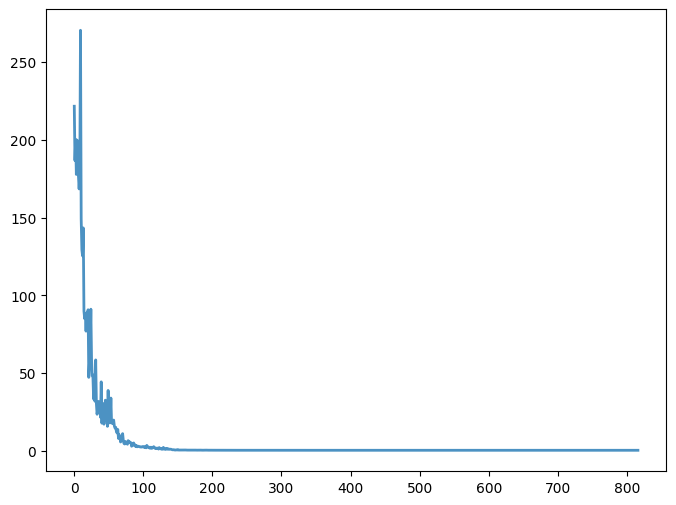

In [11]:
# Parameters

rotation_blocks=["rx", "y"]
entanglement_blocks="ecr"
entanglement="full"
reps = 1

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

reference_fval = np.array([])
prob_vqe_exact = []
error_vqe_cost = []
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = np.append(reference_fval, result_exact.fval)

# SamplingVQE result
# ansatz = EfficientSU2(num_qubits=q, reps=reps, su2_gates=su2_gates, entanglement=entanglement)
ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, 
                    entanglement=entanglement, reps=reps, entanglement_blocks=entanglement_blocks)
result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

# Function values and probabilities
fvals = np.array([s.fval for s in result_svqe.samples])
probabilities = np.array([s.probability for s in result_svqe.samples])

prob_vqe_exact.append(prob_exact(result_svqe, result_exact))
error_vqe_cost.append(result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost)


ax.plot(history["cost"] - reference_cost, lw=2, alpha=0.8, label=f"{q}")

## Sweep the SU2 gates


Starting entanglement  full ,  1  layers
Starting entanglement  full ,  2  layers
Starting entanglement  full ,  3  layers
Starting entanglement  full ,  4  layers
Starting entanglement  full ,  5  layers
Starting entanglement  full ,  6  layers
Starting entanglement  full ,  7  layers
Starting entanglement  full ,  15  layers


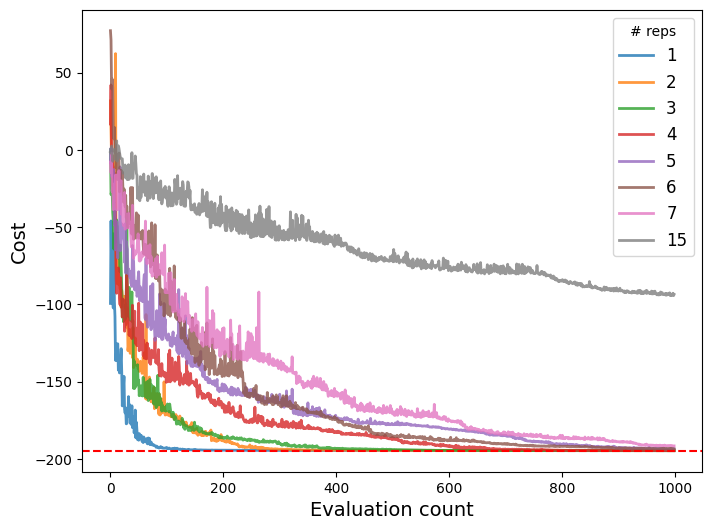

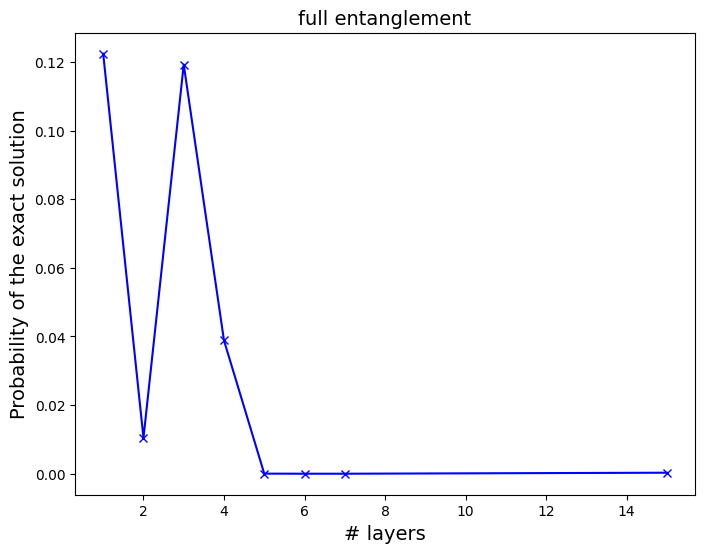

In [14]:
# Sweep number of layers

reps_sweep = [1, 2, 3, 4, 5, 6, 7, 15]
save_folder = r"/Users/romantudorgeorge/Desktop"

# Parameters
rotation_blocks=["rx", "y"]
entanglement_blocks="ecr"
entanglement="full"

# Data
qp = create_quadratic_program(sigma=sigma, mu=mu)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Make figure for cost plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Sweep
prob_vqe_exact = []
error_vqe_cost = []

for reps in reps_sweep:

    print('Starting entanglement ', entanglement, ', ', reps, ' layers')

    ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, reps=reps, entanglement_blocks=entanglement_blocks)
    # ansatz = EfficientSU2(num_qubits=num_assets, su2_gates=su2_gates, entanglement=entanglement, reps=reps)
    result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

    # Function values and probabilities
    fvals = np.array([s.fval for s in result_svqe.samples])
    probabilities = np.array([s.probability for s in result_svqe.samples])

    # Compute statistics of the results
    prob_vqe_exact.append(prob_exact(result_svqe, result_exact))
    error_vqe_cost.append(result_svqe.min_eigen_solver_result.eigenvalue.real - reference_cost)

    ax.plot(history["cost"], lw=2, alpha=0.8, label=f"{reps}")

# Complete the cost plot
ax.axhline(reference_cost, color="red", ls="--")
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="# reps", fontsize=12)
fig.savefig(save_folder + f"cost_history.png")
plt.show()

# Plot the probability of the exact solution as a function of the error in the cost function value (compared to the exact solution)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(reps_sweep, prob_vqe_exact, marker="x", color="blue")
ax.set_ylabel("Probability of the exact solution", fontsize=14)
ax.set_xlabel("# layers", fontsize=14)
ax.set_title(entanglement + r" entanglement", fontsize=14)
fig.savefig(save_folder + entanglement + r"_" + str(reps) + r"rep_prob.png")

['rx', 'y']
['ry', 'x']
['y', 'rx']
['x', 'ry']
['rx', 'ry']
['ry', 'rx']


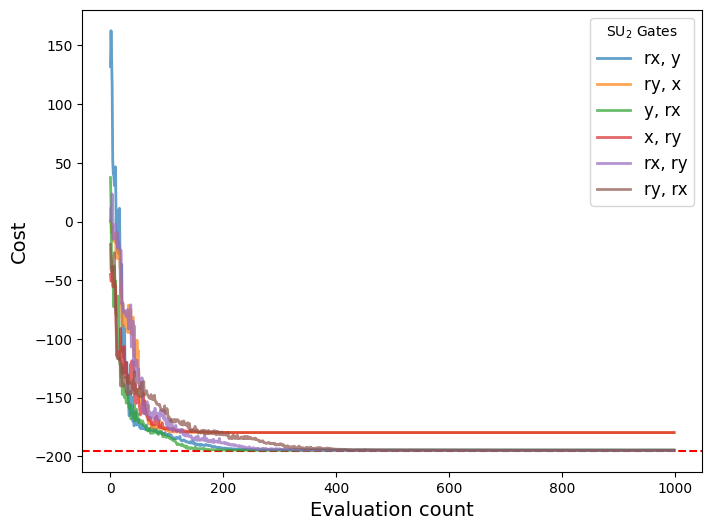

In [15]:
num_assets = 10
save_folder = r"/Users/romantudorgeorge/Desktop"

# Parameters
rotation_blocks_sweep=[["rx", "y"], ["ry", "x"], ["y", "rx"], ["x", "ry"], ["rx", "ry"], ["ry", "rx"]]
entanglement="full"
reps = 1
entanglement_blocks="ecr"

# Data
qp = create_quadratic_program(sigma=sigma, mu=mu)

# Exact result via classical eigensolver
result_exact = get_result_numpy(qp)
reference_cost = result_exact.min_eigen_solver_result.eigenvalue.real
reference_fval = result_exact.fval

# Make figure for cost plot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.axhline(reference_cost, color="red", ls="--")

# Sweep
for rotation_blocks in rotation_blocks_sweep:

    print(rotation_blocks)

    # ansatz = EfficientSU2(num_qubits=num_assets, su2_gates=su2_gates, entanglement=entanglement, reps=reps)
    ansatz = TwoLocal(num_qubits=num_assets,rotation_blocks=rotation_blocks, entanglement=entanglement, reps=reps,
                      entanglement_blocks=entanglement_blocks)

    result_svqe, history = get_result_SamplingVQE(qp, ansatz=ansatz)

    # Function values and probabilities
    fvals = np.array([s.fval for s in result_svqe.samples])
    probabilities = np.array([s.probability for s in result_svqe.samples])

    # Compute statistics of the results
    ax.plot(history["cost"], lw=2, alpha=0.7, label=rotation_blocks[0] + r", " + rotation_blocks[1])

# Complete the cost plot
ax.set_ylabel("Cost", fontsize=14)
ax.set_xlabel("Evaluation count", fontsize=14)
ax.legend(title="SU$_2$ Gates", fontsize=12)
fig.savefig(save_folder + f"cost_history.png")
plt.show()


# fetch data


In [24]:
import requests
import datetime
import math
import pandas as pd
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance (in km) between two points on Earth using the haversine formula.
    """
    R = 6371  # Earth radius in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi / 2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    return 2 * R * math.asin(math.sqrt(a))

def filter_area(df, center_lat, center_lon, radius_km=5):
    """
    Filter a DataFrame for records within a given radius (in km) of a center point.
    
    This function first performs a bounding-box filter using an approximate degree difference,
    then refines the selection using the haversine distance.
    """
    # Approximate degree difference for the given radius (1 degree ~ 111 km in latitude)
    delta = radius_km / 111  
    filtered_df = df[
        (df["latitude"].between(center_lat - delta, center_lat + delta)) &
        (df["longitude"].between(center_lon - delta, center_lon + delta))
    ].copy()
    
    # Compute precise distances and filter accordingly
    filtered_df["distance_km"] = filtered_df.apply(
        lambda row: haversine(center_lat, center_lon, row["latitude"], row["longitude"]), axis=1
    )
    return filtered_df[filtered_df["distance_km"] <= radius_km]

def filter_incidents(incidents, lat_key, lon_key, date_key, center_lat, center_lon, start_date, end_date, radius_km=5):
    """
    Filter incident records based on geographic proximity and date range.
    
    This function iterates over incident records, extracts coordinates (even from nested keys),
    computes the distance to the center using the haversine formula, and counts only those
    incidents that fall within the specified radius and date bounds.
    """
    count = 0
    for incident in incidents:
        try:
            # Extract latitude
            if '.' in lat_key:
                keys = lat_key.split('.')
                incident_lat = float(incident[keys[0]][keys[1]])
            else:
                incident_lat = float(incident[lat_key])
            # Extract longitude
            if '.' in lon_key:
                keys = lon_key.split('.')
                incident_lon = float(incident[keys[0]][keys[1]])
            else:
                incident_lon = float(incident[lon_key])
            # Skip if either coordinate is zero (invalid data)
            if incident_lat == 0 or incident_lon == 0:
                continue
            # Calculate distance and check within radius
            distance = haversine(center_lat, center_lon, incident_lat, incident_lon)
            if distance <= radius_km:
                date_str = incident[date_key]
                # Handle ISO format dates with or without a 'T' separator
                if 'T' in date_str:
                    incident_date = datetime.datetime.fromisoformat(date_str.replace('Z', '+00:00'))
                else:
                    incident_date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
                if start_date <= incident_date <= end_date:
                    count += 1
        except (KeyError, ValueError, TypeError):
            continue
    return count

def fetch_crime_data(start_date, end_date, limit=50000):
    """
    Fetch crime records from the Los Angeles open data API within the given date range.
    """
    crime_url = "https://data.lacity.org/resource/2nrs-mtv8.json"
    params = {
        "$where": f"date_rptd >= '{start_date.strftime('%Y-%m-%d')}' and date_rptd <= '{end_date.strftime('%Y-%m-%d')}'",
        "$limit": limit
    }
    try:
        response = requests.get(crime_url, params=params, timeout=10)
        response.raise_for_status()
        data = response.json()
        print(f"Fetched {len(data)} crime records.")
        return data
    except requests.RequestException as e:
        print(f"Failed to fetch crime data: {e}")
        return []

def fetch_fema_data(start_date, end_date):
    """
    Fetch FEMA disaster declarations for Los Angeles County within the given date range.
    """
    fema_url = "https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries"
    params = {
        "$filter": (
            f"state eq 'CA' and declarationDate ge '{start_date.strftime('%Y-%m-%d')}T00:00:00.000' "
            f"and declarationDate le '{end_date.strftime('%Y-%m-%d')}T23:59:59.999' and designatedArea eq 'Los Angeles (County)'"
        ),
        "$select": "declarationDate,disasterName",
        "$inlinecount": "allpages"
    }
    try:
        query_url = requests.get(fema_url, params=params, timeout=10).url
        print("FEMA query URL:", query_url)  # Debug: print query URL
        response = requests.get(fema_url, params=params, timeout=10)
        response.raise_for_status()
        fema_json = response.json()
        disasters = fema_json.get("DisasterDeclarationsSummaries", [])
        print(f"Found {len(disasters)} disaster declarations in LA County.")
        if disasters:
            for d in disasters:
                print(f" - {d['disasterName']} on {d['declarationDate']}")
        else:
            print(" - No disasters found.")
        return len(disasters)
    except requests.RequestException as e:
        print(f"Failed to fetch FEMA disaster data: {e}")
        if hasattr(e, 'response'):
            print("Response content:", e.response.text)
        return 0

In [31]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('us_disaster_declarations.csv')

# Convert the date column to datetime.
# (Assuming that the relevant date column is called 'declaration_date'. If the file has a different column name for the date, change it accordingly.)
df['declaration_date'] = pd.to_datetime(df['declaration_date'], errors='coerce')

# Choose a two-year period between 2011 and 2013.
# For example, here we choose 2011 and 2012.
years_chosen = [2011, 2012]
df_period = df[df['declaration_date'].dt.year.isin(years_chosen)]

# Specify 10 states to filter. (Adjust these state abbreviations if needed.)
states_chosen = ["TX", "CA", "FL", "NY", "IL", "NC", "GA", "AZ", "PA", "TN"]
df_filtered = df_period[df_period['state'].isin(states_chosen)]

# Group by state and count the number of disasters.
state_counts = df_filtered.groupby('state').size().reset_index(name='raw_count')

# Normalize the counts between 0 and 1.
# Normalization: (value - min) / (max - min). Ensure we handle a potential division by zero.
min_count = state_counts['raw_count'].min()
max_count = state_counts['raw_count'].max()

if max_count == min_count:
    # If all states have the same raw count, set normalized value to 1 (or any constant value)
    state_counts['normalized'] = 1.0
else:
    state_counts['normalized'] = (state_counts['raw_count'] - min_count) / (max_count - min_count) + 0.001

# Print the results: each row shows the state, the raw disaster count, and the normalized number.
print(state_counts)


  state  raw_count  normalized
0    AZ          4    0.001000
1    CA         22    0.070767
2    FL         47    0.167667
3    GA         32    0.109527
4    IL         86    0.318829
5    NC         94    0.349837
6    NY        188    0.714178
7    PA        176    0.667667
8    TN        113    0.423481
9    TX        262    1.001000
